In [29]:
import os
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [30]:
PATCH_SIZE = 64
STEP_SIZE = 32
PCA_COMPONENTS = 50

DATA_DIR = "data"
IMAGE_DIR = "data/images"
LABEL_DIR = "data/labels"

In [31]:
def get_box_coordinates(line, img_w, img_h):
    _, x_center, y_center, width, height = map(float, line.strip().split())
    x_center *= img_w
    y_center *= img_h
    width *= img_w
    height *= img_h
    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)
    return x1, y1, x2, y2

In [32]:
def extract_patches(img, bboxes, positive=True, num_random=30):
    patches = []

    if positive:
        for box in bboxes:
            x1, y1, x2, y2 = box
            patch = img[y1:y2, x1:x2]
            patch = cv2.resize(patch, (PATCH_SIZE, PATCH_SIZE))
            patches.append(patch)
    else:
        h, w = img.shape[:2]
        for _ in range(num_random):
            x = np.random.randint(0, w - PATCH_SIZE)
            y = np.random.randint(0, h - PATCH_SIZE)
            overlap = False
            for bx1, by1, bx2, by2 in bboxes:
                if not (x + PATCH_SIZE < bx1 or x > bx2 or y + PATCH_SIZE < by1 or y > by2):
                    overlap = True
                    break
            if not overlap:
                patch = img[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
                patches.append(patch)
    return patches

In [33]:
def load_dataset():
    X, y = [], []
    for fname in os.listdir(IMAGE_DIR):
        if not fname.endswith(".jpg"): continue

        img_path = os.path.join(IMAGE_DIR, fname)
        label_path = os.path.join(LABEL_DIR, fname.replace(".jpg", ".txt"))
        img = cv2.imread(img_path)
        h, w = img.shape[:2]

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                lines = f.readlines()
            bboxes = [get_box_coordinates(line, w, h) for line in lines if line.strip()]
        else:
            bboxes = []

        pos_patches = extract_patches(img, bboxes, positive=True)
        neg_patches = extract_patches(img, bboxes, positive=False)

        for patch in pos_patches:
            X.append(patch.flatten())
            y.append(1)
        for patch in neg_patches:
            X.append(patch.flatten())
            y.append(0)

    return np.array(X), np.array(y)

In [34]:
X, y = load_dataset()
X.shape, y.shape

((8162, 12288), (8162,))

In [35]:
adjusted_components = min(PCA_COMPONENTS, min(X.shape[0], X.shape[1]))
print(f"PCA with n components = {adjusted_components}")
pca = PCA(n_components=adjusted_components)
X_pca = pca.fit_transform(X)


PCA with n components = 50


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
svm = SVC(kernel="linear", probability=True)
svm.fit(X_train, y_train)

In [23]:
def detect_aircraft(img, pca, clf, threshold=0.9):
    h, w = img.shape[:2]
    boxes = []
    for y in range(0, h - PATCH_SIZE, STEP_SIZE):
        for x in range(0, w - PATCH_SIZE, STEP_SIZE):
            patch = img[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
            flat = patch.flatten().reshape(1, -1)
            flat_pca = pca.transform(flat)
            prob = clf.predict_proba(flat_pca)[0][1]
            if prob > threshold:
                boxes.append((x, y, x+PATCH_SIZE, y+PATCH_SIZE))
    return boxes


In [24]:
def draw_boxes(img, boxes):
    for x1, y1, x2, y2 in boxes:
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
    return img

In [25]:
# test
sample_img_path = '99_set1.jpg'
sample_img = cv2.imread(sample_img_path)
boxes = detect_aircraft(sample_img, pca, svm)
result_img = draw_boxes(sample_img.copy(), boxes)

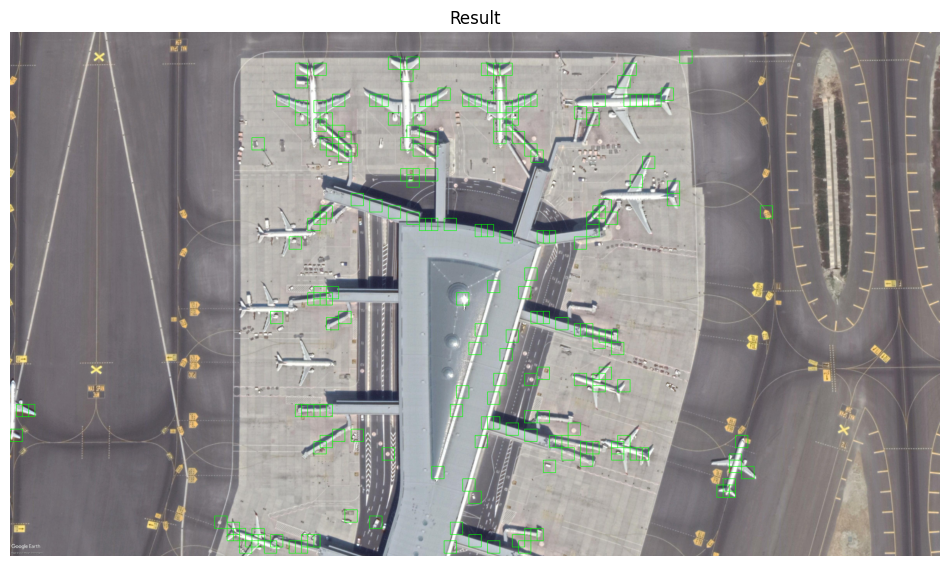

In [26]:
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.title("Result")
plt.axis('off')
plt.show()

In [27]:
sample_img_path = 'test/Shrub_860.jpg'
sample_img = cv2.imread(sample_img_path)
boxes = detect_aircraft(sample_img, pca, svm)
result_img = draw_boxes(sample_img.copy(), boxes)

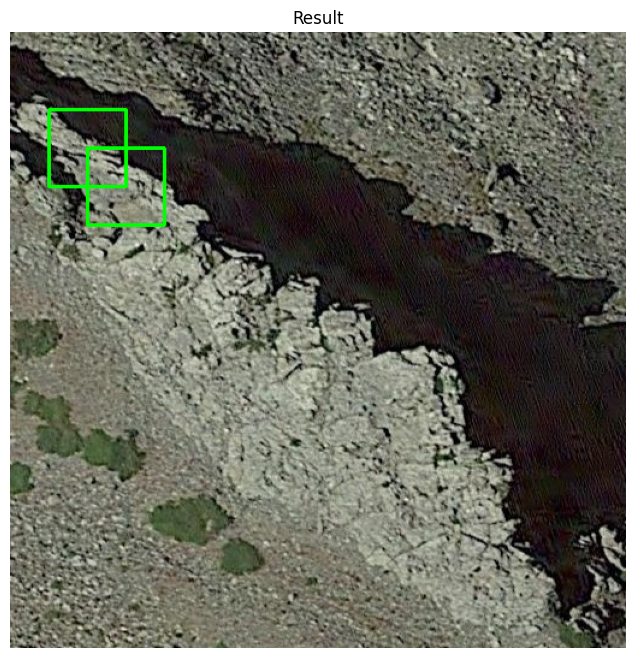

In [28]:
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.title("Result")
plt.axis('off')
plt.show()